### Performing KNN,and ROC/AUC analysis on data

- #### Procedures:
    - ##### ---------------------1.The proccess for whole features
    - ##### 1.1.Implement a KNN classifier
    - ##### 1.2.Train data with cross validation to calculate the avarage accuracy and choose the Best K and observe average accuracy
    - ##### 1.3.Predict the Y_test for submission with the classifier with Best K
    - ##### 1.4.Split train data into cross_train and cross_test to observe the accuracy,draw the ROC and calculate AUC and confusion matrix with evaluation with Best K
    - ##### ----------------------2.The proccess for subset of features by feature extraction
    - ##### 2.1..Train data with cross validation to calculate the avarage accuracy and choose the Best K and observe average accuracy
    - ##### ---------------------3.Compare the performance of KNN with whole features and subset of features with feature extraction

In [1]:
import numpy as np
import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score 
from collections import Counter
from random import seed
from random import randrange
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

- ##### ---------------------1.The proccess for whole features

#### 1.1:  Implement a KNN classifier


##### First: Load classification data
Download `X_train.csv` and `X_test.csv`,`y_train.csv` from Moodle. In X_train.csv, each row corresponds to an instance.the columns representing all of the features. The same format is used in `X_test.csv`. Load these datasets into python (numpy.loadtxt) and create an X matrix consisting of 112 columns and a Y_train as training t. Do the same for the test data so we have four objects: $\mathbf{X}_{train}$, $\mathbf{X}_{test}$, and $\mathbf{Y}_{train}$.and normalize the data

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

# Make an instance of the Model

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)


X_Y_train = np.column_stack((X_train,Y_train))
print(X_Y_train.shape)

(200, 113)


##### Second: write k-fold cross validation data spliter to split train data into k folds 

In [3]:
# Split a dataset into k folds
def cross_validation_split(data, folds):
    data_split = list()
    data_copy = list(data)
    fold_size = int(len(data) / folds)
    for i in range(folds):
        fold_list = list()
        while len(fold_list) < fold_size:
            index = randrange(len(data_copy))
            fold_list.append(data_copy.pop(index))
        data_split.append(fold_list)
    return data_split
 
# test cross validation split
seed(1)
fold = 2
splited_data = np.array(cross_validation_split(X_Y_train,fold))
print(splited_data.shape)

(2, 100, 113)


##### Third: Write a KNN function for a single test example (a row)
Implement a KNN function that takes a single test example and a value of K and returns a classification. the function will find the K closest (see below) training points to the test point and return the majority class
amongst these training points.

The distance between a test point and the ith row is given by:

`sq_difference = (test_row - X_train[i,:])**2
distance = np.sqrt(sq_difference.sum())`

where test_row is a row of $\mathbf{X}_{test}$.
The first line creates a new vector which holds the squared difference of the two pairs of values. The second line takes the sum of these differences and then takes the square root. This is computing the Euclidean distance. Other distance metrics could also be used.

the predicted score and the predicted class will be returned as dictionary

In [4]:
def knn_classifier(trainX, traint, test_data, K):
    # computing distances between the testing data(one row)to all training data
    distances = np.sqrt(((trainX - test_data)**2).sum(axis=1)) 
    # zip the train data distance and the class them below to dy 
    dy = zip(distances, traint) 
    # sort the dy bt distance
    dy = sorted(dy, key = lambda x: x[0]) 
    # select K instances of neareast neighbours
    k_selected_neighbor = np.asarray(dy[:K]) 
    classes, counts = np.unique(k_selected_neighbor[:,1], return_counts=True)
    prediction = {}
    # assign the class of training data to the testing data with the highest ammount
    prediction["predicted_class"] = classes[counts.argmax()]
    # calculate the prediction score for testing data 
    if ( len(classes) == 1 and classes[counts.argmax()] == 2.0):
        prediction["predicted_score"] = np.hstack( (1.0- (1.0*counts/sum(counts)), 1.0*counts/sum(counts) ) )
    elif ( len(classes) == 1 and classes[counts.argmax()] == 1.0):
        prediction["predicted_score"] = np.hstack( ( 1.0*counts/sum(counts), 1.0- (1.0*counts/sum(counts)) ) )
    else:
        prediction["predicted_score"] = 1.0*counts/sum(counts)
    return(prediction)

##### 1.2.Train data with cross validation to calculate the avarage accuracy and choose the Best K and observe average accuracy

In [5]:
results = []
for i in range(fold):
    fold_X_train = splited_data[i,:,:-1]
    fold_Y_train = splited_data[i,:,-1]
    cross_fold_X_train, cross_fold_X_test, cross_fold_Y_train, cross_fold_Y_test = train_test_split(fold_X_train,fold_Y_train, test_size=0.5,random_state=1234)
    ctrain = Counter(cross_fold_Y_train.flatten())
    
    Kvals = np.arange(1,100,1)
    accuracy = []

    for k in Kvals:
        correct = 0
        for i,row in enumerate(cross_fold_X_test):
            c = knn_classifier(cross_fold_X_train,cross_fold_Y_train,row,K=k)["predicted_class"]
            if c == cross_fold_Y_test[i]:
                correct += 1
        accuracy.append(1.0*correct / (1.0*len(cross_fold_X_test)))
    results.append((max(accuracy),np.array(accuracy).argmax()))
print(results)
temp = 0
k = 0
for (i,j) in results:
    temp += i
    k += j
print("The average accuracy :",temp/len(results))
print("The average k :",k/len(results))








[(0.82, 7), (0.9, 0)]
The average accuracy : 0.86
The average k : 3.5


##### 1.3.Predict the Y_test for submission with the classifier with Best K

In [6]:
y_prediction = []
for i in range(len(X_test)):
    c = knn_classifier(X_train,Y_train,X_test[i,:],K=4)
    y_prediction.append(c["predicted_class"])
y_prediction = np.array(y_prediction)

In [7]:
test_header = "Id,EpiOrStroma"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = y_prediction[:,0]
print(y_pred_pp)

np.savetxt('my_submission_k_nearest_neighbour_cl.csv', y_pred_pp, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.   2.]
 [  1.   2.]
 [  2.   2.]
 ...
 [795.   1.]
 [796.   2.]
 [797.   2.]]


##### 1.4.Split train data into cross_train and cross_test again to observe the accuracy for comfirmation,draw the ROC and calculate AUC with Best K

In [8]:
cross_X_train, cross_X_test, cross_Y_train, cross_Y_test = train_test_split(X_train,Y_train, test_size=0.5,random_state=1234)

In [9]:
predictions_knn = np.zeros((100, 3))
for j,tx in enumerate(cross_X_test):
    knn_results = knn_classifier(cross_X_train, cross_Y_train, tx, K = 4)
    predictions_knn[j, 0] = knn_results['predicted_class']
    predictions_knn[j, 1:] = knn_results['predicted_score']

##### First: test the cross_X_test 's ROC curves

Text(0, 0.5, 'Sensitivity or True Positive Rate')

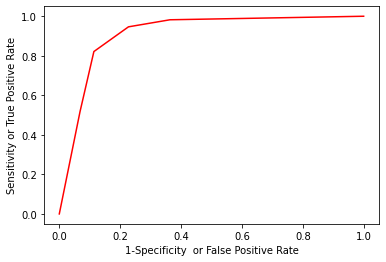

In [10]:
fpr_knn, tpr_knn, th_knn = roc_curve(cross_Y_test-1, predictions_knn[:,2])
plt.plot(fpr_knn, tpr_knn, "r")
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")


##### second:  Compute the AUC for KNN classifier 

AUCs range between 0.5 and 1. Higher AUC indicates better classifier

In [11]:
auc_knn = roc_auc_score(cross_Y_test-1, predictions_knn[:,2])
print(auc_knn)


0.9107142857142858


#### Forth:Draw the confusion matrix for identifying TP,TF,FP,FN for evaluation

In [12]:
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))

In [13]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




Evaluation for: description
Classifier 'description' has Acc=0.850 P=0.854 R=0.849 F1=0.849
              precision    recall  f1-score   support

         1.0      0.886     0.796     0.839        49
         2.0      0.821     0.902     0.860        51

    accuracy                          0.850       100
   macro avg      0.854     0.849     0.849       100
weighted avg      0.853     0.850     0.849       100

Confusion matrix, without normalization
[[39  5]
 [10 46]]


c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

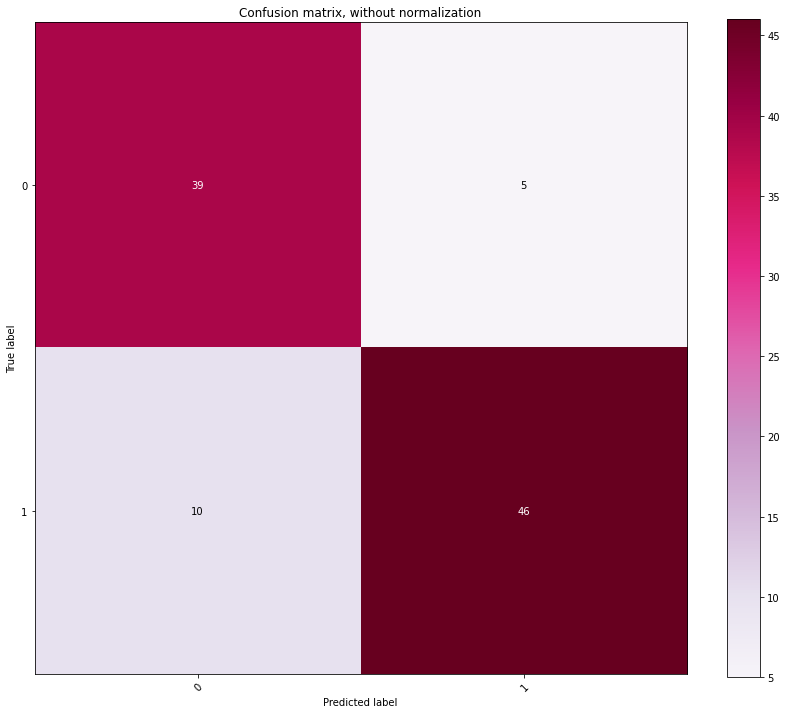

In [14]:
print()
evaluation_summary("description", predictions_knn[:, 0], cross_Y_test)
plot_confusion_matrix(cross_Y_test, predictions_knn[:, 0],normalize=False,
                          title=None,
                          cmap=plt.cm.PuRd)

- ##### ---------------------2.The proccess for subset of features by feature extraction

In [15]:
fs=feature_selection.SelectPercentile(percentile=2)
X_train_sub=fs.fit_transform(X_train,Y_train)
X_test_sub = fs.transform(X_test)

Y_train_sub = Y_train

X_Y_train_sub = np.column_stack((X_train_sub,Y_train_sub))
print(X_Y_train_sub.shape)

(200, 4)


c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [85] are constant.
  UserWarning)
c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


##### First:split sub-feature data into k-folds 

In [16]:
seed(1)
fold_sub = 2
splited_data_sub = np.array(cross_validation_split(X_Y_train_sub,fold_sub))
print(splited_data_sub.shape)

(2, 100, 4)


#### 2.1..Train data with cross validation to calculate the avarage accuracy and choose the Best K and observe average accuracy

In [17]:
result_sub = []
for i in range(fold_sub):
    fold_X_train_sub = splited_data_sub[i,:,:-1]
    fold_Y_train_sub = splited_data_sub[i,:,-1]
    cross_fold_X_train_sub, cross_fold_X_test_sub, cross_fold_Y_train_sub, cross_fold_Y_test_sub = train_test_split(fold_X_train_sub,fold_Y_train_sub, test_size=0.5,random_state=1234)
    ctrain = Counter(cross_fold_Y_train_sub.flatten())
    
    Kvals = np.arange(1,100,1)
    accuracy = []

    for k in Kvals:
        correct = 0
        for i,row in enumerate(cross_fold_Y_test_sub):
            c = knn_classifier(cross_fold_X_train_sub,cross_fold_Y_train_sub,row,K=k)["predicted_class"]
            if c == cross_fold_Y_test_sub[i]:
                correct += 1
        accuracy.append(1.0*correct / (1.0*len(cross_fold_Y_test_sub)))
    result_sub.append((max(accuracy),np.array(accuracy).argmax()))
print(result_sub)
temp = 0
k = 0
for (i,j) in result_sub:
    temp += i
    k += j
print("The average accuracy :",temp/len(result_sub))
print("The average k :",k/len(result_sub))

[(0.42, 0), (0.52, 0)]
The average accuracy : 0.47
The average k : 0.0


- ##### ---------------------3.Compare the performance of KNN with whole features and subset of features

### The performance for the whole feature data using KNN sharing the average accuracy around 0.86 with k-fold cross validation,whereas the performance for subset of feature(20 features) data using KNN sharing the average accuracy around 0.47 using k-fold cross validation with same k folds,which indicate the for KNN classifier ,the accuracy might be higher for that classifier if we deploy more features